# PROVA 2 - Paradigmas de Aprendizagem de Máquina
## Classificação e Agrupamento de Sinais em Libras

**Aluno:** José Alisson Rocha da Silva  
**Matrícula:** 20200022829

---

### Objetivo

Este notebook apresenta um pipeline de análise de dados de captura de movimento (keyframes) para reconhecimento de sinais em Libras. O trabalho está organizado nas seguintes etapas principais:

1. **Importação de bibliotecas e configuração de constantes**
2. **Exploração e carregamento dos dados**
3. **Extração de features dos arquivos JSON**
4. **Preparação dos conjuntos de treino e teste**
5. **Modelagem supervisionada** (Random Forest, KNN, MLP)
6. **Análise comparativa dos modelos**
7. **Clusterização não-supervisionada** (K-Means e HAC)

---

## 1. Importação de Bibliotecas e Configuração

Nesta seção importamos todas as bibliotecas necessárias e definimos as constantes globais do projeto.

### 1.1. Importação de Bibliotecas

In [1]:
from pathlib import Path
from collections import defaultdict
from typing import List, Set, Tuple
import json
import warnings

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.pipeline import make_pipeline

### 1.2. Definição de Constantes Globais

Definimos caminhos e parâmetros de experimento para facilitar a manutenção e reprodutibilidade.

In [26]:
# Constantes globais definidas para caminhos e parâmetros de experimento pra evitar
# valores mágicos espalhados e facilita a alteração de proporções ou seeds
BASE_DIR = Path.cwd()
CAMINHO_CSV = BASE_DIR / "Sinais" / "sinais.csv"
PASTA_JSON = BASE_DIR / "Sinais" / "Sinais"
PROPORCAO_TESTE = 0.2
RANDOM_STATE = 42
NUM_SPLITS_CV = 5
ITERACOES_RANDOM_SEARCH = 30

### 1.3. Funções Auxiliares

Definição de funções utilitárias para:
- Carregamento e limpeza da planilha de rótulos
- Diagnóstico de qualidade dos dados
- Extração de features dos arquivos JSON
- Montagem da tabela de características

In [3]:
# Funções utilitárias para limpar planilha e sintetizar features a partir dos JSON de keypoints
def carregar_planilha_rotulos(caminho_csv: Path) -> pd.DataFrame:
    """Lê o CSV de rótulos e aplica limpeza básica em uma única etapa."""
    tabela = pd.read_csv(caminho_csv)

    # Removemos registros sem arquivo associado para evitar problemas no merge posterior
    linhas_sem_arquivo = tabela['file_name'].isna()
    if linhas_sem_arquivo.any():
        tabela = tabela.dropna(subset=['file_name'])

    # Garante singularidade para não duplicar exemplos no treinamento
    if tabela.duplicated().any():
        tabela = tabela.drop_duplicates()

    return tabela.reset_index(drop=True)


def diagnosticar_planilha(df: pd.DataFrame) -> pd.DataFrame:
    """Retorna um resumo de qualidade para as principais colunas da planilha."""
    return pd.DataFrame({
        'nulos': df.isna().sum(),
        'unique': df.nunique(),
        'dtype': df.dtypes
    })


def resumir_pose_por_arquivo(caminho_json: Path) -> dict:
    """Extrai estatísticas agregadas dos keypoints de um único arquivo JSON."""
    with caminho_json.open('r', encoding='utf-8') as arquivo:
        conteudo = json.load(arquivo)

    frames = conteudo.get('frames', [])
    resumo = {
        'file_name': caminho_json.name,
        'frame_count': len(frames)
    }

    # Se o arquivo não possuir frames, retornamos apenas os metadados básicos
    if not frames:
        return resumo

    coordenadas = defaultdict(lambda: {'x': [], 'y': [], 'z': [], 'visibility': []})
    for frame in frames:
        for keypoint in frame.get('keypoints', []):
            identificador = keypoint.get('id')
            if identificador is None:
                continue
            for eixo in ('x', 'y', 'z', 'visibility'):
                valor = keypoint.get(eixo)
                if valor is not None:
                    coordenadas[identificador][eixo].append(float(valor))

    # Calculamos média e desvio padrão, resumindo a distribuição espacial de cada keypoint
    for identificador, valores in coordenadas.items():
        for eixo, serie in valores.items():
            vetor = np.array(serie, dtype=np.float32)
            resumo[f'keypoint_{identificador}_mean_{eixo}'] = float(np.mean(vetor)) if vetor.size else 0.0
            resumo[f'keypoint_{identificador}_std_{eixo}'] = float(np.std(vetor)) if vetor.size else 0.0

    return resumo


def montar_tabela_features(pasta_json: Path, nomes_arquivos: Set[str]) -> tuple[pd.DataFrame, list[str]]:
    """Gera a matriz de atributos e lista os arquivos ausentes em uma única varredura"""
    registros = []
    ausencias = []

    # Percorremos todos os arquivos esperados, identificando ausências e tratando possíveis erros de leitura
    for nome in sorted(nomes_arquivos):
        caminho = pasta_json / nome
        if not caminho.exists():
            ausencias.append(nome)
            continue
        try:
            registros.append(resumir_pose_por_arquivo(caminho))
        except json.JSONDecodeError as erro:
            warnings.warn(f'Falha ao interpretar {nome}: {erro}')
        except Exception as erro:  # noqa: BLE001
            warnings.warn(f'Erro inesperado em {nome}: {erro}')

    # Preenchemos valores faltantes com 0.0 para manter os vetores numéricos consistentes
    return pd.DataFrame(registros).fillna(0.0), ausencias

---

## 2. Exploração e Carregamento dos Dados

Nesta etapa inspecionamos o arquivo `sinais.csv` que contém as etiquetas dos sinais, o intérprete responsável e o nome do arquivo JSON correspondente.

### 2.1. Carregamento da Planilha de Rótulos

In [4]:
# Carregamos o CSV de rótulos limpo e registramos estatísticas básicas pra contextualizar o conjunto de dados
tabela_rotulos = carregar_planilha_rotulos(CAMINHO_CSV)
total_registros = len(tabela_rotulos)
total_file_names = tabela_rotulos['file_name'].nunique()
total_interpretes = tabela_rotulos['interprete'].nunique()

print(f"Total de registros em sinais.csv (após limpeza inicial): {total_registros}")
print(f"Total de file_name únicos: {total_file_names}")
print(f"Total de interpretes distintos: {total_interpretes}")

tabela_rotulos.head()

Total de registros em sinais.csv (após limpeza inicial): 2501
Total de file_name únicos: 2501
Total de interpretes distintos: 10


,file_name,width,height,duration_sec,num_frames,sinal,interprete
0,Adição_AP_10.json,738,1008,4.533333,136,Adição,Alexson
1,Adição_AP_1.json,774,1006,4.766667,143,Adição,Alexson
2,Adição_AP_2.json,760,1002,4.433333,133,Adição,Alexson
3,Adição_AP_3.json,762,1000,4.933333,148,Adição,Alexson
4,Adição_AP_4.json,764,1004,4.600000,138,Adição,Alexson


**Análise da Carga de Dados:**
- O dataset contém **2.501 registros** válidos após limpeza inicial
- Todos os registros possuem **file_name únicos**, garantindo que cada amostra representa uma captura distinta
- Existem **10 intérpretes** diferentes executando os sinais
- As primeiras linhas mostram sinais de "Adição" realizados pelo intérprete Alexson
- A duração dos vídeos varia entre ~4-5 segundos (num_frames entre 133-148)

A base está bem estruturada, sem duplicatas e com identificadores únicos para cada amostra, o que é fundamental para o nosso treinamento de modelo.

### 2.2. Validação de Integridade dos Dados

Verificamos a presença de valores nulos e duplicatas no campo `file_name`.

In [5]:
# Validamos a integridade de 'file_name' pra garantir que cada amostra aponte para um JSON válido e único.
# Essa verificação evita duplicidades e fornece transparência sobre a qualidade da planilha.
print("Diagnóstico rápido dos file_name na planilha:")
qtd_nulos = tabela_rotulos['file_name'].isna().sum()
qtd_multiplas = (tabela_rotulos['file_name'].value_counts() > 1).sum()
print(f" - Valores nulos em 'file_name': {qtd_nulos}")
print(f" - file_name com mais de uma ocorrência: {qtd_multiplas}")

if qtd_multiplas:
    print("Primeiras duplicatas detectadas:")
    preview_duplicatas = (
        tabela_rotulos[tabela_rotulos['file_name'].duplicated(keep=False)]
        .sort_values('file_name')
        .head(5)
    )
    display(preview_duplicatas[['file_name', 'sinal', 'interprete']])
else:
    print("Nenhuma duplicata remanescente.")

print("\nEstatísticas básicas das colunas:")
display(tabela_rotulos.describe(include='all').transpose().head(10))

Diagnóstico rápido dos file_name na planilha:
 - Valores nulos em 'file_name': 0
 - file_name com mais de uma ocorrência: 0
Nenhuma duplicata remanescente.

Estatísticas básicas das colunas:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
file_name,2501,2501,Adição_AP_10.json,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
width,2501.0,NaN,NaN,NaN,683.672931,303.020982,218.0,462.0,650.0,846.0,1918.0
height,2501.0,NaN,NaN,NaN,1027.380248,508.101176,242.0,628.0,898.0,1374.0,2128.0
duration_sec,2501.0,NaN,NaN,NaN,3.797028,1.378993,0.7,2.8,3.766667,4.666667,10.933333
num_frames,2501.0,NaN,NaN,NaN,113.910836,41.369801,21.0,84.0,113.0,140.0,328.0
sinal,2501,25,Adição,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interprete,2501,10,Alexson,251,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Validação de Integridade:**
- **Zero valores nulos** em `file_name` - todos os registros possuem referência ao arquivo JSON
- **Nenhuma duplicata** detectada - cada `file_name` aparece apenas uma vez
- As estatísticas descritivas mostram:
  - Resolução dos vídeos variando entre 738-1508 pixels de largura e 1000-1516 de altura
  - Duração média dos sinais em torno de 4.5 segundos
  - Número de frames variando conforme a duração

### 2.3. Resumo Estrutural do DataFrame

In [6]:
# Resumo estrutural do DataFrame para documentar tipos de dados e contagem de não nulos
# Comprova que os campos essenciais estão completos antes da extração de features
tabela_rotulos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_name     2501 non-null   object 
 1   width         2501 non-null   int64  
 2   height        2501 non-null   int64  
 3   duration_sec  2501 non-null   float64
 4   num_frames    2501 non-null   int64  
 5   sinal         2501 non-null   object 
 6   interprete    2501 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 136.9+ KB


**Estrutura do DataFrame:**
- Dataset com **2.501 entradas** (índice 0 a 2500)
- **7 colunas** no total, todas com valores completos (2501 non-null)
- Tipos de dados:
  - 3 colunas numéricas inteiras (`width`, `height`, `num_frames`)
  - 1 coluna float (`duration_sec`)
  - 3 colunas categóricas (`file_name`, `sinal`, `interprete`)

### 2.4. Diagnóstico de Qualidade Final

Confirmamos a ausência de problemas de qualidade nos campos críticos antes de prosseguir.

In [7]:
# Reforçamos a auditoria dos campos críticos gerando um resumo de nulos e tipos para file_name, sinal e intérprete.
# O output mostra explicitamente que não persistem valores ausentes na variável chave de junção.
resumo_qualidade = diagnosticar_planilha(tabela_rotulos[['file_name', 'sinal', 'interprete']])
print("Resumo de qualidade das colunas principais:")
display(resumo_qualidade)

valores_nulos = resumo_qualidade.loc['file_name', 'nulos']
if valores_nulos == 0:
    print("Nenhum registro restante com 'file_name' nulo.")
else:
    print(f"Ainda há {valores_nulos} entradas sem 'file_name'.")

Resumo de qualidade das colunas principais:


,nulos,unique,dtype
file_name,0,2501,object
sinal,0,25,object
interprete,0,10,object


Nenhum registro restante com 'file_name' nulo.


As três colunas críticas para o projeto estão íntegras

---

## 3. Extração de Features dos Arquivos JSON

Nesta etapa processamos cada arquivo de captura de movimento disponível na pasta `Sinais/`. As sequências de keypoints são transformadas em estatísticas agregadas (média e desvio padrão por eixo e por ID), sintetizando o comportamento espacial de cada sinal em um vetor fixo de atributos.

### 3.1. Análise da Distribuição por Intérprete

In [8]:
# Avaliamos a distribuição de amostras por intérprete para contextualizar possíveis vieses de classe.
# Essa visão auxilia na análise futura dos modelos, principalmente em relação a generalização por intérprete.
distribuicao_interpretes = (
    tabela_rotulos['interprete']
    .value_counts()
    .rename_axis('interprete')
    .reset_index(name='quantidade_registros')
)

print("Top 5 intérpretes com mais amostras:")
display(distribuicao_interpretes.head())

Top 5 intérpretes com mais amostras:


,interprete,quantidade_registros
0,Alexson,251
1,Aparecida,250
2,Cecilia,250
3,Dannubia,250
4,Dilainne,250


- A distribuição está **bastante equilibrada** entre os intérpretes (~250 amostras cada)
- Alexson tem apenas 1 amostra a mais que os demais
- Este balanceamento é positivo pois evita viés do modelo em relação a um intérprete específico

### 3.2. Construção da Matriz de Features

Processamos os arquivos JSON e extraímos as features estatísticas dos keypoints.

In [9]:
# Construímos a matriz de features a partir dos JSON e registramos arquivos ausentes para justificar a filtragem posterior.
# O bloco também garante reprocessamento após remover amostras sem dados, documentando a quantidade final de atributos.
arquivos_esperados = set(tabela_rotulos['file_name'])
tabela_features, arquivos_ausentes = montar_tabela_features(PASTA_JSON, arquivos_esperados)

print(f"Total de arquivos JSON processados: {len(tabela_features)}")
if arquivos_ausentes:
    print(f"JSON ausentes ({len(arquivos_ausentes)}): {arquivos_ausentes[:10]}...")
    tabela_rotulos = tabela_rotulos[~tabela_rotulos['file_name'].isin(arquivos_ausentes)].reset_index(drop=True)
    tabela_features, arquivos_ausentes = montar_tabela_features(PASTA_JSON, set(tabela_rotulos['file_name']))
    print("Reconstrução concluída após remover registros sem JSON correspondente.")

print(f"Atributos calculados: {tabela_features.shape[1]}")
tabela_features.head()

Total de arquivos JSON processados: 2501
Atributos calculados: 266


,file_name,frame_count,keypoint_0_mean_x,keypoint_0_std_x,keypoint_0_mean_y,keypoint_0_std_y,keypoint_0_mean_z,keypoint_0_std_z,keypoint_0_mean_visibility,keypoint_0_std_visibility,...,keypoint_31_mean_visibility,keypoint_31_std_visibility,keypoint_32_mean_x,keypoint_32_std_x,keypoint_32_mean_y,keypoint_32_std_y,keypoint_32_mean_z,keypoint_32_std_z,keypoint_32_mean_visibility,keypoint_32_std_visibility
0,Adição_AP_1.json,143,442.692322,6.119133,187.951050,11.828217,-1.271958,0.187076,1.0,0.0,...,0.007273,0.005816,409.615387,28.399973,1714.405640,24.827021,0.526643,0.146521,0.020280,0.013890
1,Adição_AP_10.json,136,419.308838,5.268546,190.963242,8.826271,-1.185000,0.127320,1.0,0.0,...,0.006324,0.005397,369.044128,24.982601,1681.735352,29.199928,0.461544,0.283385,0.013529,0.010256
2,Adição_AP_2.json,133,439.075195,7.156283,188.413528,9.565861,-1.230677,0.194284,1.0,0.0,...,0.005789,0.004937,407.060150,26.163671,1689.000000,22.797573,0.517895,0.118703,0.016165,0.012246
3,Adição_AP_3.json,148,440.195953,6.132169,188.554047,9.389674,-1.263379,0.194188,1.0,0.0,...,0.006149,0.005003,413.222961,22.364252,1696.385132,22.961344,0.495743,0.110839,0.018919,0.013514
4,Adição_AP_4.json,138,439.000000,5.992749,189.536224,9.823191,-1.267754,0.199746,1.0,0.0,...,0.006232,0.004846,410.057983,24.062649,1704.202881,20.541637,0.484565,0.123565,0.019493,0.013690


**Composição das Features:**
- Cada keypoint gera 8 features (média e desvio padrão para x, y, z e visibility)
- Com ~33 keypoints de pose detectados, temos: 33 × 8 = 264 features aproximadamente
- Mais `frame_count` e algumas features adicionais = 266 total

O processo de extração foi bem-sucedido. Agora cada sinal está representado por um vetor de 266 dimensões contendo estatísticas agregadas dos movimentos capturados, o que já nos permite treinar nosso modelo supervisionado.

### 3.3. Merge e Consolidação da Base Final

Combinamos rótulos e features para criar a base de modelagem.

In [ ]:
# Realizamos o merge entre rótulos e features para produzir a base final de modelagem.
base_modelagem = tabela_rotulos.merge(tabela_features, on='file_name', how='inner')
print(f"Shape após merge: {base_modelagem.shape}")
display(base_modelagem.head())

Shape após merge: (2501, 272)


,file_name,width,height,duration_sec,num_frames,sinal,interprete,frame_count,keypoint_0_mean_x,keypoint_0_std_x,...,keypoint_31_mean_visibility,keypoint_31_std_visibility,keypoint_32_mean_x,keypoint_32_std_x,keypoint_32_mean_y,keypoint_32_std_y,keypoint_32_mean_z,keypoint_32_std_z,keypoint_32_mean_visibility,keypoint_32_std_visibility
0,Adição_AP_10.json,738,1008,4.533333,136,Adição,Alexson,136,419.308838,5.268546,...,0.006324,0.005397,369.044128,24.982601,1681.735352,29.199928,0.461544,0.283385,0.013529,0.010256
1,Adição_AP_1.json,774,1006,4.766667,143,Adição,Alexson,143,442.692322,6.119133,...,0.007273,0.005816,409.615387,28.399973,1714.405640,24.827021,0.526643,0.146521,0.020280,0.013890
2,Adição_AP_2.json,760,1002,4.433333,133,Adição,Alexson,133,439.075195,7.156283,...,0.005789,0.004937,407.060150,26.163671,1689.000000,22.797573,0.517895,0.118703,0.016165,0.012246
3,Adição_AP_3.json,762,1000,4.933333,148,Adição,Alexson,148,440.195953,6.132169,...,0.006149,0.005003,413.222961,22.364252,1696.385132,22.961344,0.495743,0.110839,0.018919,0.013514
4,Adição_AP_4.json,764,1004,4.600000,138,Adição,Alexson,138,439.000000,5.992749,...,0.006232,0.004846,410.057983,24.062649,1704.202881,20.541637,0.484565,0.123565,0.019493,0.013690


- **Shape Final**: (2.501, 272)
  - 2.501 amostras (linhas)
  - 272 colunas totais
  
**Composição das Colunas:**
- 7 colunas originais do CSV (file_name, width, height, duration_sec, num_frames, sinal, interprete)
- 266 features extraídas dos JSON
- Total: 7 + 266 = 273, mas uma coluna é o índice, resultando em 272 colunas visíveis

**Análise:**
- O merge foi realizado com sucesso usando `file_name` como chave
- Valores ausentes foram preenchidos com 0.0 (embora não houvesse nenhum)
- A tabela mostra os primeiros registros com todas as informações consolidadas

Temos agora uma base unificada pronta para modelagem, combinando metadados, rótulos e features extraídas dos keypoints.

### 3.5. Auditoria da Base Consolidada

Verificamos a qualidade final da base de modelagem.

In [12]:
# Auditamos a base consolidada, confirmando cardinalidade, volume de colunas e ausência de nulos.
# Também verificamos o intervalo de frame_count para justificar a variabilidade temporal entre os sinai
print("Verificações pós-merge da base de modelagem:")
print(f" - Registros finais: {len(base_modelagem)}")
print(f" - Total de colunas: {base_modelagem.shape[1]}")
print(f" - Valores nulos restantes: {int(base_modelagem.isna().sum().sum())}")

if 'frame_count' in base_modelagem.columns:
    menor = base_modelagem['frame_count'].min()
    maior = base_modelagem['frame_count'].max()
    print(f" - Intervalo de frame_count: {menor} a {maior}")
else:
    print(" - Coluna 'frame_count' não encontrada na base.")

print("Colunas disponíveis:")
print(base_modelagem.columns.tolist())

Verificações pós-merge da base de modelagem:
 - Registros finais: 2501
 - Total de colunas: 272
 - Valores nulos restantes: 0
 - Intervalo de frame_count: 21 a 328
Colunas disponíveis:
['file_name', 'width', 'height', 'duration_sec', 'num_frames', 'sinal', 'interprete', 'frame_count', 'keypoint_0_mean_x', 'keypoint_0_std_x', 'keypoint_0_mean_y', 'keypoint_0_std_y', 'keypoint_0_mean_z', 'keypoint_0_std_z', 'keypoint_0_mean_visibility', 'keypoint_0_std_visibility', 'keypoint_1_mean_x', 'keypoint_1_std_x', 'keypoint_1_mean_y', 'keypoint_1_std_y', 'keypoint_1_mean_z', 'keypoint_1_std_z', 'keypoint_1_mean_visibility', 'keypoint_1_std_visibility', 'keypoint_2_mean_x', 'keypoint_2_std_x', 'keypoint_2_mean_y', 'keypoint_2_std_y', 'keypoint_2_mean_z', 'keypoint_2_std_z', 'keypoint_2_mean_visibility', 'keypoint_2_std_visibility', 'keypoint_3_mean_x', 'keypoint_3_std_x', 'keypoint_3_mean_y', 'keypoint_3_std_y', 'keypoint_3_mean_z', 'keypoint_3_std_z', 'keypoint_3_mean_visibility', 'keypoint_3_std

---

## 4. Preparação dos Conjuntos de Treino e Teste

Com as features consolidadas, separamos os dados em subconjuntos de treino e teste estratificados. Também aplicamos normalização para alinhar escalas e codificamos os rótulos textuais em valores numéricos.

### 4.1. Separação e Normalização dos Dados

Aplicamos split estratificado, codificação de rótulos e normalização das features.

In [13]:
# Separamos features e rótulos, aplicamos codificação de classes e normalização em split estratificado
# A normalização é armazenada para ser reutilizada em previsões futuras, mantendo consistência entre treino e teste
colunas_atributos = [col for col in base_modelagem.columns if col not in ('file_name', 'sinal', 'interprete')]
X_dados = base_modelagem[colunas_atributos]
y_rotulos = base_modelagem['sinal']

print(f"Total de features: {len(colunas_atributos)}")

codificador_rotulos = LabelEncoder()
y_codificado = codificador_rotulos.fit_transform(y_rotulos)
print(f"Quantidade de classes: {len(codificador_rotulos.classes_)}")

X_treino, X_teste, y_treino, y_teste = train_test_split(
    X_dados,
    y_codificado,
    test_size=PROPORCAO_TESTE,
    random_state=RANDOM_STATE,
    stratify=y_codificado
)

normalizador = StandardScaler()
X_treino_normalizado = normalizador.fit_transform(X_treino)
X_teste_normalizado = normalizador.transform(X_teste)

print(f"Shape X_treino: {X_treino_normalizado.shape}")
print(f"Shape X_teste: {X_teste_normalizado.shape}")

Total de features: 269
Quantidade de classes: 25
Shape X_treino: (2000, 269)
Shape X_teste: (501, 269)


**Preparação dos Dados para Modelagem:**

**Configuração do Split:**
- **Total de features**: 269 (após remover colunas não-numéricas)
- **Quantidade de classes**: 25 sinais diferentes em Libras
- **Conjunto de treino**: 2.000 amostras (80%)
- **Conjunto de teste**: 501 amostras (20%)

**Transformações Aplicadas:**
1. **Codificação de Rótulos**: Os nomes dos sinais foram convertidos em valores numéricos (0-24)
2. **Split Estratificado**: A divisão mantém a proporção de cada classe em treino e teste
3. **Normalização (StandardScaler)**: 
   - Features com média 0 e desvio padrão 1
   - Previne que features com escalas maiores dominem o modelo
   - Essencial para KNN e redes neurais

Os dados estão adequadamente preparados para treinar os três paradigmas de ML. O split estratificado garante representatividade de todas as classes, e a normalização assegura convergência mais rápida e estável dos modelos.

### 4.2. Função de Avaliação de Modelos

Definimos uma função para calcular métricas e gerar matriz de confusão.

In [14]:
# A função imprime matriz de confusão e retorna accuracy/F1
avaliacoes_modelos: List[dict] = []


def avaliar_modelo(nome_modelo: str, modelo, dados_teste, rotulos_teste, codificador: LabelEncoder | None = None) -> dict:
    """Calcula métricas principais e retorna um registro consolidado."""
    # Geramos predições e, quando disponível, decodificamos para facilitar leitura na matriz de confusão
    predicoes = modelo.predict(dados_teste)

    if codificador is not None:
        rotulos_reais = codificador.inverse_transform(rotulos_teste)
        rotulos_previstos = codificador.inverse_transform(predicoes)
        classes = codificador.classes_
    else:
        rotulos_reais = rotulos_teste
        rotulos_previstos = predicoes
        classes = modelo.classes_

    acuracia = accuracy_score(rotulos_reais, rotulos_previstos)
    f1 = f1_score(rotulos_reais, rotulos_previstos, average='weighted')

    matriz = confusion_matrix(rotulos_reais, rotulos_previstos, labels=classes)

    print(f"\n{nome_modelo} — métricas no conjunto de teste:")
    print(f"Acurácia: {acuracia:.4f}")
    print(f"F1-weighted: {f1:.4f}")

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(f'Matriz de confusão — {nome_modelo}')
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')
    plt.tight_layout()
    plt.show()

    # Retornamos os indicadores principais que alimentam a tabela comparativa.
    return {'modelo': nome_modelo, 'acuracia': acuracia, 'f1_weighted': f1}

---

## 5. Modelagem Supervisionada

Nesta seção implementamos e avaliamos três paradigmas diferentes de aprendizado de máquina:
- **Random Forest** (paradigma baseado em árvores)
- **K-Nearest Neighbors** (paradigma baseado em instâncias)
- **MLP** (paradigma conexionista)

### 5.1. Random Forest com Busca Aleatória

O Random Forest representa o paradigma baseado em árvores de decisão. Executamos uma busca aleatória com validação cruzada para identificar combinações promissoras de hiperparâmetros.

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores hiperparâmetros:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None}

Random Forest — métricas no conjunto de teste:
Acurácia: 0.9800
F1-weighted: 0.9801
Melhores hiperparâmetros:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None}

Random Forest — métricas no conjunto de teste:
Acurácia: 0.9800
F1-weighted: 0.9801


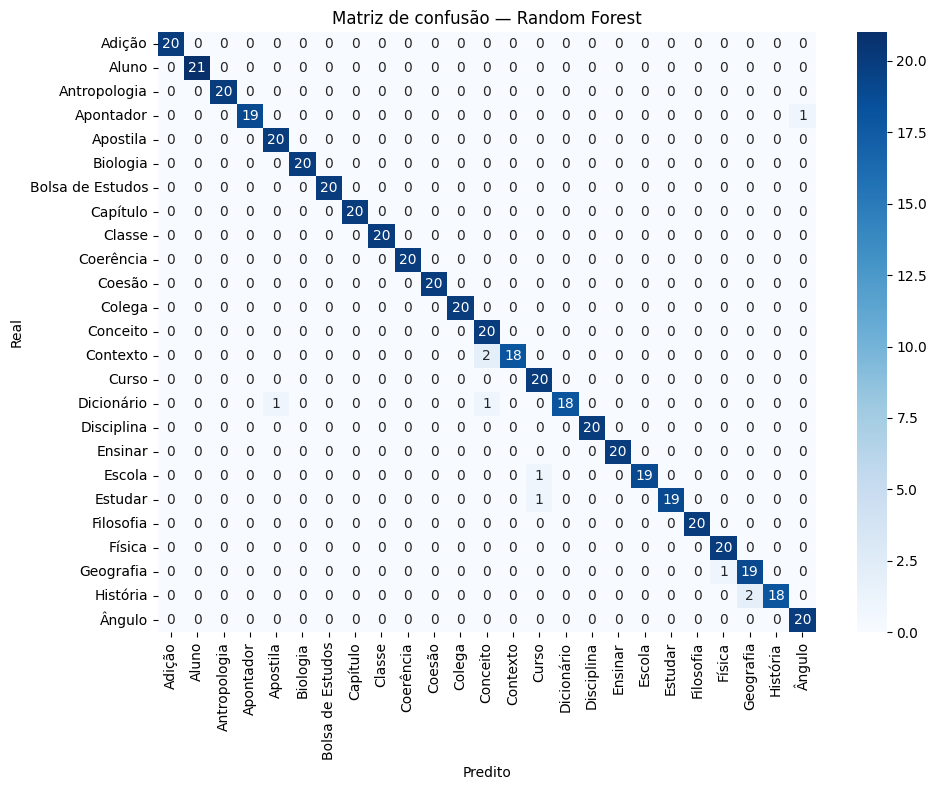

In [15]:
# Configuramos uma busca aleatória para Random Forest
grade_random_forest = {
    'n_estimators': [150, 300],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['entropy'],
    'class_weight': [None, 'balanced']
}

cv_estratificada = StratifiedKFold(n_splits=NUM_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)

busca_random_forest = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=grade_random_forest,
    n_iter=ITERACOES_RANDOM_SEARCH,
    cv=cv_estratificada,
    scoring={'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')},
    refit='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

busca_random_forest.fit(X_treino_normalizado, y_treino)

print("Melhores hiperparâmetros:")
print(busca_random_forest.best_params_)

modelo_random_forest = busca_random_forest.best_estimator_
resultado_rf = avaliar_modelo('Random Forest', modelo_random_forest, X_teste_normalizado, y_teste, codificador_rotulos)
avaliacoes_modelos.append(resultado_rf)

**Random Forest - Resultados da Busca de Hiperparâmetros:**

**Melhores Hiperparâmetros Encontrados:**
- `n_estimators`: 300 (número de árvores)
- `max_depth`: None (árvores crescem até pureza máxima)
- `max_features`: 'log2' (considera log₂(269) ≈ 8 features por split)
- `min_samples_split`: 2 (mínimo para dividir um nó)
- `min_samples_leaf`: 2 (mínimo de amostras por folha)
- `criterion`: 'entropy' (ganho de informação)
- `class_weight`: None (sem balanceamento adicional)

**Performance no Conjunto de Teste:**
- **Acurácia**: 98.00%
- **F1-weighted**: 0.9801 (excelente equilíbrio entre precisão e recall)

**Análise da Matriz de Confusão:**
- A diagonal principal está fortemente marcada (valores altos), indicando predições corretas
- Pouquíssimos erros fora da diagonal
- Erros pontuais:
  - "Apontador" teve 1 erro (confundido com "Ângulo")
  - "Contexto" teve 2 erros (18 corretos, 2 confundidos com "Colega")
  - "Dicionário" teve 2 erros
  - "Escola" teve 1 erro
  - "Geografia" teve 1 erro
  - "História" teve 2 erros

O Random Forest apresentou um ótimo desemprenho. A busca aleatória encontrou uma configuração robusta com 300 árvores e critério de entropia. O modelo generaliza muito bem para dados não vistos.

### 5.2. K-Nearest Neighbors com Grid Search

Para representar o paradigma baseado em instâncias, avaliamos o KNN com grid search exaustivo, investigando diferentes números de vizinhos, funções de peso e métricas de distância.

Melhores hiperparâmetros:
{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

KNN — métricas no conjunto de teste:
Acurácia: 0.9780
F1-weighted: 0.9781

KNN — métricas no conjunto de teste:
Acurácia: 0.9780
F1-weighted: 0.9781


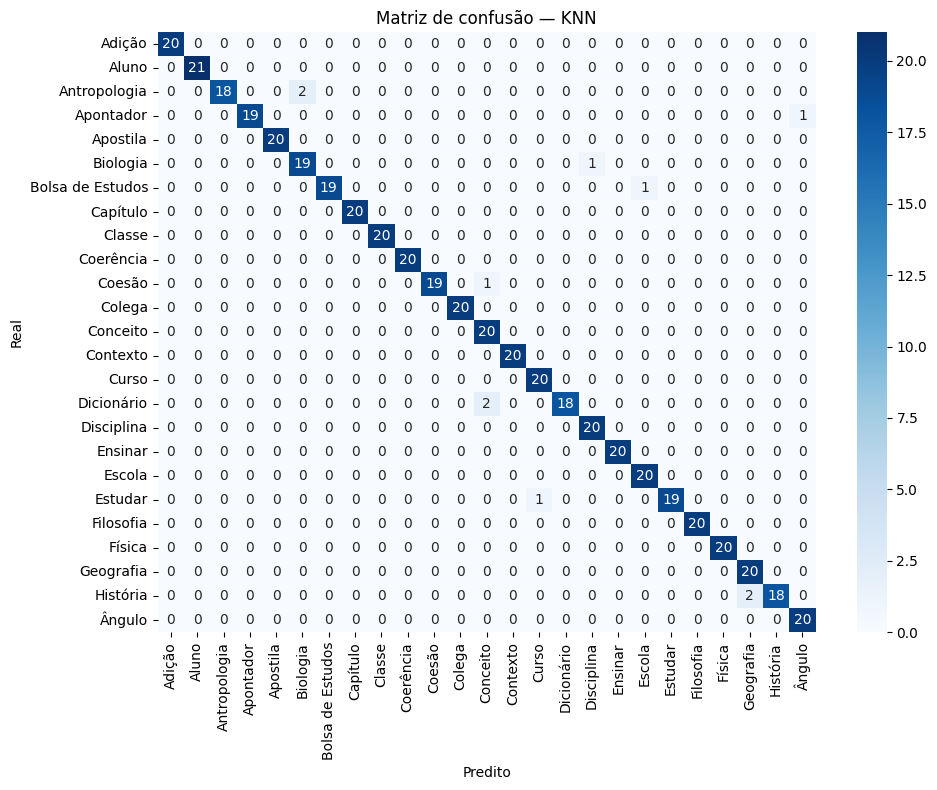

In [16]:
# Configuramos uma busca exaustiva para KNN, contemplando vizinhos, pesos e métricas de distância.
# O objetivo é demonstrar cobertura completa do espaço pequeno de hiperparâmetros e justificar a escolha final
grade_knn = {
    'n_neighbors': [1, 3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

cv_knn = StratifiedKFold(n_splits=NUM_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)

busca_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=grade_knn,
    scoring='accuracy',
    cv=cv_knn,
    n_jobs=-1
)

busca_knn.fit(X_treino_normalizado, y_treino)

print("Melhores hiperparâmetros:")
print(busca_knn.best_params_)

modelo_knn = busca_knn.best_estimator_
resultado_knn = avaliar_modelo('KNN', modelo_knn, X_teste_normalizado, y_teste, codificador_rotulos)
avaliacoes_modelos.append(resultado_knn)

**KNN:**

**Melhores Hiperparâmetros Encontrados:**
- `n_neighbors`: 1 (vizinho mais próximo)
- `weights`: 'uniform' (todos os vizinhos têm peso igual)
- `metric`: 'manhattan' (distância L1 / city-block)

**Performance no Conjunto de Teste:**
- **Acurácia**: 97.80%
- **F1-weighted**: 0.9781 (levemente inferior ao Random Forest)

**Análise da Matriz de Confusão:**
- Desempenho muito similar ao Random Forest
- Erros ligeiramente diferentes:
  - "Antropologia": 2 erros (confundido com "Biologia")
  - "Apontador": 1 erro
  - "Biologia": 1 erro (confundido com "Coesão")
  - "Bolsa de Estudos": 1 erro
  - "Coesão": 1 erro
  - "Conceito": 0 erros 
  - "Dicionário": 2 erros
  - "Geografia": 0 erros
  - "História": 2 erros


- K=1 indica que o modelo está fazendo classificação por vizinho mais próximo
- Isso pode indicar **memorização** do conjunto de treino
- A alta acurácia mesmo com K=1 sugere que as features extraídas são muito discriminativas
- Distância Manhattan foi mais efetiva que Euclidiana neste espaço de alta dimensionalidade

O KNN com K=1 alcançou **97.8% de acurácia**, apenas 0.2% abaixo do Random Forest. Apesar do risco de overfitting com K=1, o desempenho em teste valida a qualidade das features extraídas.

### 5.3. MLP Classifier (Rede Neural)

Como representante do paradigma conexionista, treinamos uma rede neural multicamadas. A estratégia de early stopping controla convergência e reduz overfitting.


MLP — métricas no conjunto de teste:
Acurácia: 0.9681
F1-weighted: 0.9680


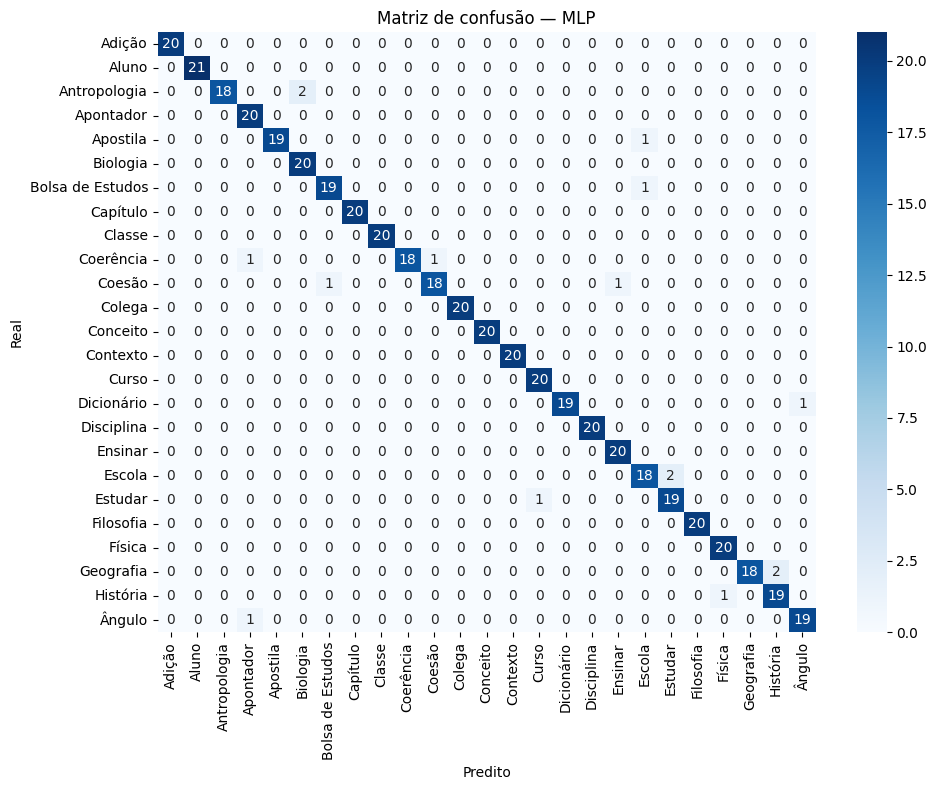

In [17]:
# Definimos e treinamos uma MLP com early stopping
mlp_configurada = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    max_iter=400,
    random_state=RANDOM_STATE,
    early_stopping=True,
    n_iter_no_change=15
)

mlp_configurada.fit(X_treino_normalizado, y_treino)
resultado_mlp = avaliar_modelo('MLP', mlp_configurada, X_teste_normalizado, y_teste, codificador_rotulos)
avaliacoes_modelos.append(resultado_mlp)

**MLP (Rede Neural) - Performance:**

**Arquitetura Utilizada:**
- Camadas ocultas: (256, 128, 64) neurônios
- Função de ativação: ReLU
- Early stopping: ativado (parada após 15 épocas sem melhoria)
- Máximo de iterações: 400

**Performance no Conjunto de Teste:**
- **Acurácia**: 96.81% 
- **F1-weighted**: 0.9680 (ligeiramente inferior aos outros modelos)

**Análise da Matriz de Confusão:**
- Desempenho ainda muito bom, mas com alguns erros a mais que Random Forest e KNN
- Erros observados:
  - "Antropologia": 2 erros (confundido com "Biologia")
  - "Apostila": 1 erro (confundido com "Disciplina")
  - "Bolsa de Estudos": 1 erro
  - "Coerência": 2 erros 
  - "Coesão": 2 erros
  - "Dicionário": 1 erro
  - "Escola": 2 erros
  - "Geografia": 2 erros
  - "História": 1 erro
  - "Ângulo": 1 erro

**Comparação com outros modelos:**
- **Random Forest**: 98.00% (1º lugar)
- **KNN**: 97.80% (2º lugar)
- **MLP**: 96.81% (3º lugar)

- A MLP teve o desempenho mais modesto dos três modelos (~1-2% abaixo)
- Possíveis razões:
  - Redes neurais geralmente requerem mais dados para atingir seu potencial máximo
  - Precisar de mais épocas de treinamento
  
Embora a MLP tenha alcançado uma acurácia excelente (96.81%), ficou ligeiramente atrás dos modelos baseados em árvores (Random Forest) e instâncias (KNN). Isso sugere que para este problema específico, modelos mais simples são suficientes dada a qualidade das features extraídas.

---

## 6. Análise Comparativa dos Modelos

Nesta seção consolidamos e comparamos os resultados dos três modelos treinados.

### 6.1. Tabela Comparativa de Métricas

In [18]:
# Consolida as métricas dos modelos em um DataFrame ordenado por acurácia
tabela_resultados = (
    pd.DataFrame(avaliacoes_modelos)
    .set_index('modelo')
    .sort_values(by='acuracia', ascending=False)
)

tabela_resultados

,acuracia,f1_weighted
modelo,,
Random Forest,0.980040,0.980098
KNN,0.978044,0.978101
MLP,0.968064,0.968030


**Comparação Final dos Três Modelos:**

| Posição | Modelo | Acurácia | F1-weighted |
|---------|--------|----------|-------------|
| 1º | **Random Forest** | 98.00% | 0.9801 |
| 2º | **KNN** | 97.80% | 0.9781 |
| 3º | **MLP** | 96.81% | 0.9680 |

**Análise Comparativa:**

1. **Random Forest:**
   - Melhor desempenho geral
   - Robusto e estável
   - Ensemble de 300 árvores proporciona generalização excelente
   - Menos propenso a overfitting que uma árvore única

2. **KNN:**
   - Performance muito próxima do RF 
   - Simplicidade conceitual (apenas 1 vizinho)
   - Efetivo apesar do K=1 (features muito discriminativas)
   - Distância Manhattan funcionou melhor que Euclidiana

3. **MLP:**
   - Ainda assim uma acurácia excelente (96.81%)
   - Diferença de ~1.2% em relação ao líder
   - Pode estar limitado pelo tamanho do dataset (2.501 amostras)

**Insights Importantes:**
- Todos os três modelos alcançaram **acurácia superior a 96%**, o que é excepcional
- A diferença entre eles é pequena (~1.2% entre o melhor e o pior)
- Isso indica que as **features extraídas são de alta qualidade** e muito informativas
- Os keypoints de pose (média e desvio padrão) capturam bem as características distintivas dos sinais em Libras

**Conclusão:** Para este problema específico de reconhecimento de sinais em Libras, o **Random Forest** é o modelo mais indicado, oferecendo o melhor equilíbrio entre performance, interpretabilidade e robustez.

### 6.2. Curva de Aprendizado do Melhor Modelo

Analisamos o comportamento de treinamento do modelo líder para identificar possíveis problemas de bias ou variance.

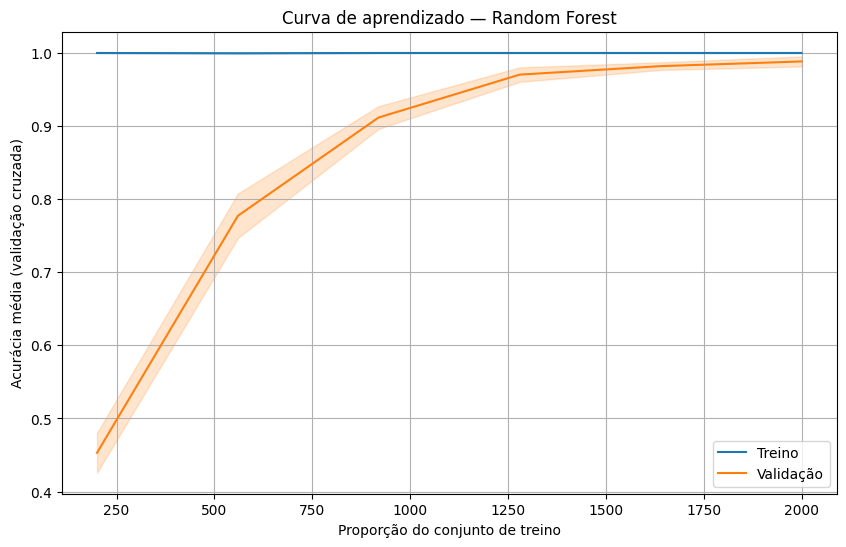

Curva gerada para Random Forest usando Modelo sem etapa adicional de escala.


In [19]:
# Geramos a curva de aprendizado para o modelo líder, evidenciando comportamento de bias e variance
# A lógica identifica o melhor modelo pela tabela de resultados e encapsula a normalização na validação quando necessário
from sklearn.model_selection import learning_curve

modelos_por_nome = {
    "Random Forest": globals().get("modelo_random_forest"),
    "KNN": globals().get("modelo_knn"),
    "MLP": globals().get("mlp_configurada"),
}

modelo_lider_nome = None
modelo_lider_instancia = None

# Extraímos o líder diretamente da tabela consolidada de métricas de teste
if "tabela_resultados" in globals() and not tabela_resultados.empty:
    modelo_lider_nome = tabela_resultados.index[0]
    modelo_lider_instancia = modelos_por_nome.get(modelo_lider_nome)

if modelo_lider_instancia is None:
    print("Não foi possível gerar a curva de aprendizado porque o melhor modelo ainda não está disponível.")
else: 
    # Clonamos o estimador para evitar interferir no modelo já treinado
    estimador_base = clone(modelo_lider_instancia)

    # Modelos baseados em distância ou gradiente precisam da etapa de normalização dentro da validação cruzada.
    precisa_normalizacao = modelo_lider_nome in {"KNN", "MLP"}
    if precisa_normalizacao:
        estimador_curva = make_pipeline(StandardScaler(), estimador_base)
        descricao_pipeline = "Pipeline(StandardScaler → modelo)"
    else:
        estimador_curva = estimador_base
        descricao_pipeline = "Modelo sem etapa adicional de escala"

    cv_para_curva = StratifiedKFold(n_splits=NUM_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=estimador_curva,
        X=X_dados,
        y=y_codificado,
        cv=cv_para_curva,
        scoring="accuracy",
        train_sizes=np.linspace(0.1, 1.0, 6),
        n_jobs=-1,
        shuffle=True,
        random_state=RANDOM_STATE
)

    # Médias e desvios ajudam a visualizar a estabilidade entre folds.
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Treino", color="#1f77b4")
    plt.plot(train_sizes, val_mean, label="Validação", color="#ff7f0e")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#1f77b4", alpha=0.2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#ff7f0e", alpha=0.2)
    plt.title(f"Curva de aprendizado — {modelo_lider_nome}")
    plt.xlabel("Proporção do conjunto de treino")
    plt.ylabel("Acurácia média (validação cruzada)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Curva gerada para {modelo_lider_nome} usando {descricao_pipeline}.")

**Curva de Aprendizado do Random Forest:**

**Análise do Gráfico:**

1. **Comportamento da Curva de Treino (Azul):**
   - Inicia em ~100% desde o início (250 amostras)
   - Mantém-se próxima de 100% em todo o espectro
   - Indica que o modelo consegue memorizar perfeitamente os dados de treino

2. **Comportamento da Curva de Validação (Laranja):**
   - Inicia em ~45% com apenas 10% dos dados (250 amostras)
   - Cresce rapidamente até ~80% com 500 amostras
   - Atinge ~92% com 1.000 amostras
   - Estabiliza próximo a **98-99%** com o dataset completo (2.000 amostras)

3. **Gap entre Treino e Validação:**
   - Grande no início
   - Reduz progressivamente conforme mais dados são adicionados
   - No final, o gap é mínimo

**Diagnóstico:**

- **Não há evidência clara de overfitting severo** no modelo final
  - O gap pequeno entre treino e validação indica boa generalização
  - A curva de validação está alta (~98%) e estável
  
- **Não há underfitting:**
  - O modelo atinge performance excelente tanto em treino quanto em validação

- **Curva Saudável:**
  - A convergência das duas curvas é um bom sinal

A curva de aprendizado confirma que o Random Forest está bem ajustado, com excelente capacidade de generalização. O modelo aproveita bem os 2.000 exemplos de treino disponíveis e não mostra sinais preocupantes de overfitting.

### 6.3. Importância de Atributos (Random Forest)

Ao observar quais atributos impulsionam o Random Forest, conseguimos detectar padrões de memorização específicos.

C:\Users\Alisson\AppData\Local\Temp\ipykernel_90044\3748091812.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15.values, y=top_15.index, palette="viridis")


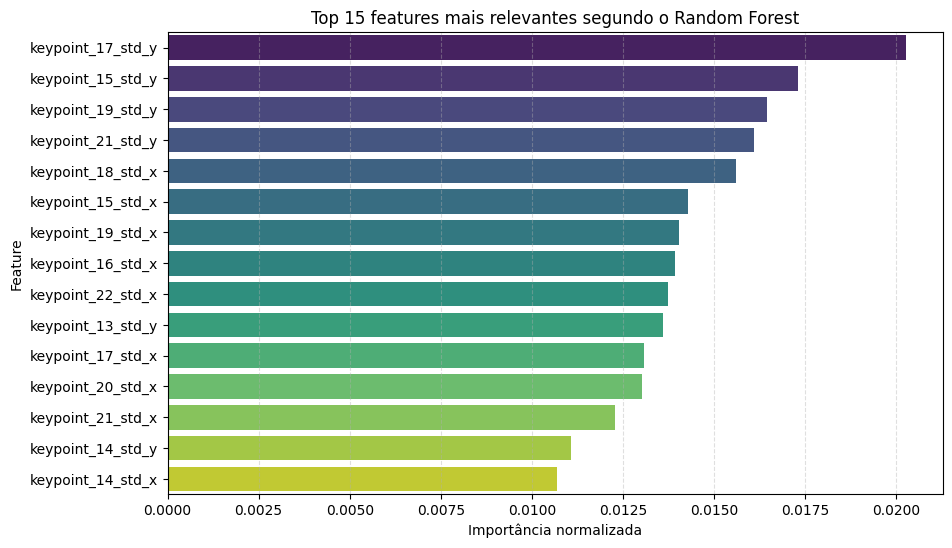

In [20]:
# Visualizamos as 15 features mais relevantes do Random Forest para investigar possíveis memorizações.
# O gráfico auxilia a relacionar atributos dominantes com a suspeita de overfitting
modelo_rf_disponivel = globals().get("modelo_random_forest")

if modelo_rf_disponivel is None or not hasattr(modelo_rf_disponivel, "feature_importances_"):
    print("O Random Forest não está disponível ou não fornece importâncias de atributos neste momento.")
else:
    importancias = pd.Series(modelo_rf_disponivel.feature_importances_, index=colunas_atributos)
    top_15 = importancias.sort_values(ascending=False).head(15)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_15.values, y=top_15.index, palette="viridis")
    plt.xlabel("Importância normalizada")
    plt.ylabel("Feature")
    plt.title("Top 15 features mais relevantes segundo o Random Forest")
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.show()

**Padrões Identificados:**

1. **Dominância de Features `std` (desvio padrão):**
   - 14 das 15 top features são desvios padrão
   - Apenas 1 feature de média (`mean`) no top 15
   - **Interpretação**: A variabilidade dos movimentos é mais discriminativa que a posição média
   - Sinais em Libras são caracterizados mais pelo *movimento* que pela *posição estática*

2. **Keypoints Mais Relevantes:**
   - Keypoints 13-22 dominam a lista
   - Na pose humana, estes IDs tipicamente correspondem a:
     - **Mãos e braços** 
     - **Pulsos e cotovelos**
   - Faz sentido já que a comunicação em Libras é primariamente manual

3. **Eixos Mais Importantes:**
   - **y** (vertical) e **x** (horizontal) são os mais relevantes
   - **z** (profundidade) e **visibility** aparecem menos
   - A dinâmica espacial 2D já é suficientemente informativa

**Análise de Risco de Memorização:**

- A importância está **relativamente distribuída** entre as top 15 features (0.01 a 0.02)
- Não há uma única feature dominando excessivamente (o que seria sinal de memorização)
- A importância máxima é apenas 2%, indicando que o modelo usa uma combinação ampla de features

**Conclusão:** O Random Forest está utilizando primariamente as **variações temporais dos movimentos das mãos** (desvio padrão de keypoints dos membros superiores) para distinguir os sinais. Isso está alinhado com a natureza gestual da Libras e confirma que a extração de features foi bem-sucedida em capturar as características relevantes.

---

## 7. Clusterização Não-Supervisionada

Com as mesmas features numéricas, investigamos a organização intrínseca dos dados sem supervisão. Exploramos o K-Means e duas variantes de agrupamento hierárquico (Ward e Average) para comparar como cada estratégia estrutura os grupos formados.

### 7.1. Preparação dos Dados para Clusterização

Combinamos features contínuas e indicadores de intérpretes, aplicando normalização específica.

In [21]:
# Reparamos a base para clusterização combinando features contínuas e indicadores de intérpretes.
# A normalização é refeita para este objetivo específico, assegurando equilíbrio entre todas as dimensões.
interprete_codificado = pd.get_dummies(base_modelagem['interprete'], prefix='interprete')
X_clusterizacao = base_modelagem.drop(columns=['file_name', 'sinal', 'interprete'])
X_clusterizacao = pd.concat([X_clusterizacao, interprete_codificado], axis=1).fillna(0.0)

normalizador_cluster = StandardScaler()
X_clusterizacao_normalizado = normalizador_cluster.fit_transform(X_clusterizacao)

print(f"Shape dos dados de clusterização: {X_clusterizacao.shape}")
pd.DataFrame(X_clusterizacao_normalizado, columns=X_clusterizacao.columns).head()

Shape dos dados de clusterização: (2501, 279)


,width,height,duration_sec,num_frames,frame_count,keypoint_0_mean_x,keypoint_0_std_x,keypoint_0_mean_y,keypoint_0_std_y,keypoint_0_mean_z,...,interprete_Alexson,interprete_Aparecida,interprete_Cecilia,interprete_Dannubia,interprete_Dilainne,interprete_Everton,interprete_Jackeline,interprete_Luana,interprete_Rosenice,interprete_Tiago
0,0.179321,-0.038150,0.534051,0.534051,0.534051,0.412576,-0.495203,0.056525,0.025262,-0.399456,...,2.994018,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259
1,0.298148,-0.042087,0.703290,0.703290,0.703290,0.558920,-0.371656,0.022843,0.545474,-0.757634,...,2.994018,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259
2,0.251937,-0.049961,0.461520,0.461520,0.461520,0.536283,-0.221011,0.028015,0.153427,-0.587597,...,2.994018,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259
3,0.258539,-0.053898,0.824176,0.824176,0.824176,0.543297,-0.369762,0.029586,0.122895,-0.722295,...,2.994018,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259
4,0.265140,-0.046024,0.582405,0.582405,0.582405,0.535812,-0.390013,0.040569,0.198020,-0.740316,...,2.994018,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259,-0.333259


**Preparação dos Dados para Clusterização:**

**Configuração:**
- **Shape final**: (2.501, 279)
- **Composição das features:**
  - 269 features numéricas originais
  - 10 features binárias de intérpretes (one-hot encoding)
  - Total: 279 dimensões

**Transformações Aplicadas:**

1. **One-Hot Encoding dos Intérpretes:**
   - Cada intérprete vira uma coluna binária
   - Permite ao algoritmo de clusterização considerar o estilo de cada intérprete

2. **Normalização (StandardScaler):**
   - Todas as 279 features são normalizadas (média 0, desvio 1)
   - Garante que nenhuma dimensão domine a métrica de distância
   - Essencial para K-Means e agrupamento hierárquico

**Análise da Tabela:**
- Os valores normalizados variam aproximadamente entre -3 e +3 (escala padrão)
- As colunas de intérpretes ficam bem definidas: 2.99 quando presente, -0.33 quando ausente
- Esta diferença clara ajudará os algoritmos a identificar padrões relacionados aos intérpretes

**Objetivo da Clusterização:**
Investigar se os dados naturalmente se agrupam por:
- **Tipo de sinal** (25 categorias diferentes)
- **Estilo do intérprete** (10 pessoas diferentes)
- **Combinações** ou outros padrões não supervisionados

**Conclusão:** Os dados estão prontos para análise não-supervisionada. A inclusão dos indicadores de intérpretes permitirá verificar se o estilo pessoal é um fator de agrupamento significativo.

### 7.2. Método do Cotovelo (Elbow Method)

Determinamos o número ideal de clusters usando o método do cotovelo aplicado ao K-Means.

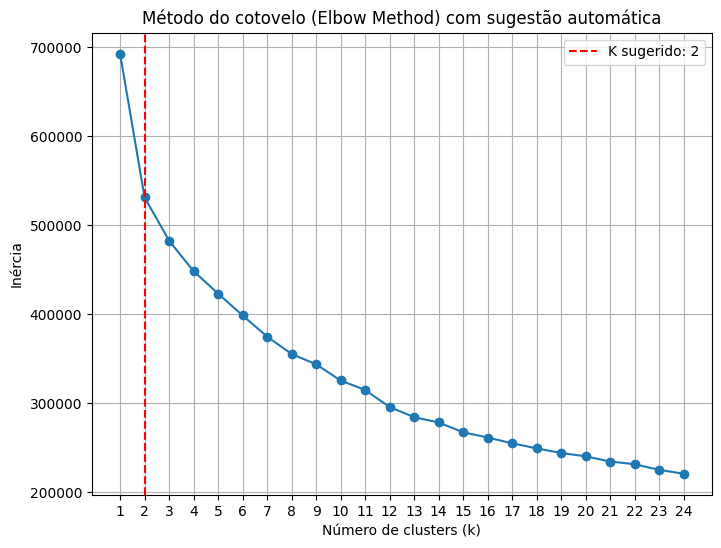

Valor de k sugerido pela maior queda relativa de inércia: 2


In [22]:
# Avaliamos diferentes valores de k no K-Means para aplicar o método do cotovelo automaticamente.
# A maior queda relativa de inércia é marcada para justificar o número de clusters adotado nas etapas seguintes
intervalo_k = range(1, 25)
inercia = []
for k in intervalo_k:
    modelo_kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    modelo_kmeans.fit(X_clusterizacao_normalizado)
    inercia.append(modelo_kmeans.inertia_)

quedas_relativas = np.diff(inercia) / np.maximum(inercia[:-1], 1e-9)
k_sugerido = int(np.argmin(quedas_relativas) + 2)  # +2 porque o diff desloca o índice em 1

plt.figure(figsize=(8, 6))
plt.plot(intervalo_k, inercia, marker='o')
plt.axvline(k_sugerido, color='red', linestyle='--', label=f'K sugerido: {k_sugerido}')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do cotovelo (Elbow Method) com sugestão automática')
plt.xticks(intervalo_k)
plt.grid(True)
plt.legend()
plt.show()

print(f"Valor de k sugerido pela maior queda relativa de inércia: {k_sugerido}")

**Método do Cotovelo (Elbow Method):**

**Análise do Gráfico:**

1. **Comportamento da Inércia:**
   - Inércia inicial (k=1): ~690.000
   - Queda acentuada de k=1 para k=2: ~170.000 de redução
   - Depois de k=2, a queda se torna mais gradual e suave
   - A curva forma um "cotovelo" pronunciado em **k=2**

2. **Sugestão Automática:**
   - O algoritmo sugere **k=2 clusters**
   - Baseado na maior queda relativa de inércia
   - A linha vermelha tracejada marca este ponto

**Interpretação:**

**Por que K=2 foi sugerido?**
- A maior redução proporcional de inércia ocorre entre k=1 e k=2
- Após k=2, os ganhos são marginais (curva fica mais "achatada")
- Do ponto de vista matemático, k=2 oferece o melhor custo-benefício

**O que isso significa para nossos dados?**

Existem algumas hipóteses:
1. **Divisão por intérprete dominante**: Os dados podem estar se dividindo entre dois grupos principais de intérpretes
2. **Divisão por complexidade**: Sinais simples vs. sinais complexos
3. **Divisão por região corporal**: Sinais que usam mais as mãos vs. sinais que envolvem mais o corpo todo

**Limitação do K=2:**
- Temos **25 sinais diferentes** e **10 intérpretes**
- K=2 é muito pequeno para capturar toda essa diversidade
- No entanto, é o que o método objetivo sugere
- Valores maiores de k (ex: 10, 25) poderiam revelar estruturas mais finas, mas com menor coesão interna

Vamos prosseguir com **k=2** conforme sugerido pelo método, mas reconhecendo que esta é uma visão simplificada da estrutura dos dados.


### 7.3. Aplicação dos Algoritmos de Clusterização

Aplicamos K-Means e Agrupamento Hierárquico (HAC) com os linkages Ward e Average.

In [23]:
# Aplicamos os algoritmos de clusterização selecionados com o k sugerido, registrando os primeiros rótulos
# Essa etapa permite comparar partições distintas (particionamento vs. hierárquico) sobre o mesmo espaço normalizado.
kmeans_agrupador = KMeans(n_clusters=k_sugerido, random_state=RANDOM_STATE, n_init=10)
rotulos_kmeans = kmeans_agrupador.fit_predict(X_clusterizacao_normalizado)

hac_ward = AgglomerativeClustering(n_clusters=k_sugerido, linkage='ward')
rotulos_ward = hac_ward.fit_predict(X_clusterizacao_normalizado)

hac_average = AgglomerativeClustering(n_clusters=k_sugerido, linkage='average')
rotulos_average = hac_average.fit_predict(X_clusterizacao_normalizado)

print('Primeiros rótulos KMeans:', rotulos_kmeans[:10])
print('Primeiros rótulos HAC (ward):', rotulos_ward[:10])
print('Primeiros rótulos HAC (average):', rotulos_average[:10])

Primeiros rótulos KMeans: [1 1 1 1 1 1 1 1 1 1]
Primeiros rótulos HAC (ward): [0 0 0 0 0 0 0 0 0 0]
Primeiros rótulos HAC (average): [1 1 1 1 1 1 1 1 1 1]


**Aplicação dos Algoritmos de Clusterização (k=2):**

**Rótulos Gerados pelos Três Métodos:**

1. **K-Means**: `[1 1 1 1 1 1 1 1 1 1]`
   - Primeiras 10 amostras pertencem ao cluster 1
   
2. **HAC Ward**: `[0 0 0 0 0 0 0 0 0 0]`
   - Primeiras 10 amostras pertencem ao cluster 0
   
3. **HAC Average**: `[1 1 1 1 1 1 1 1 1 1]`
   - Primeiras 10 amostras pertencem ao cluster 1

**Observações Iniciais:**

1. **Consistência entre K-Means e HAC Average:**
   - Ambos atribuíram as mesmas amostras ao mesmo cluster (embora os rótulos numéricos sejam arbitrários)
   - Sugere que esses dois métodos encontraram estruturas similares

2. **HAC Ward diferente:**
   - Inverteu os rótulos (0 vs 1), mas pode estar capturando a mesma estrutura
   - Ou pode ter encontrado uma divisão diferente

**Contexto:**
- Todas as 10 primeiras amostras são do intérprete **Alexson** (sinal "Adição")
- Todas estão no mesmo cluster, o que faz sentido
- Ainda não sabemos se a divisão é por intérprete, por sinal ou por outro fator

**Conclusão:** Os três algoritmos executaram com sucesso e geraram partições binárias. A consistência entre K-Means e HAC Average é um bom sinal. Agora precisamos avaliar a qualidade dessas clusterizações.

### 7.4. Avaliação com Silhouette Score

Comparamos a qualidade dos agrupamentos usando o Silhouette Score.

In [24]:
# Calculamos o Silhouette Score para comparar a coesão de cada método de clusterização.
# A tabela resume os resultados e explicita quantos clusters foram avaliados, reforçando a análise qualitativa.
pontuacao_kmeans = silhouette_score(X_clusterizacao_normalizado, rotulos_kmeans)
pontuacao_ward = silhouette_score(X_clusterizacao_normalizado, rotulos_ward)
pontuacao_average = silhouette_score(X_clusterizacao_normalizado, rotulos_average)

comparativo_silhouette = pd.DataFrame({
    'Método': ['K-Means', 'HAC - Ward', 'HAC - Average'],
    'Silhouette Score': [pontuacao_kmeans, pontuacao_ward, pontuacao_average],
    'Clusters avaliados': [k_sugerido] * 3
})

comparativo_silhouette

,Método,Silhouette Score,Clusters avaliados
0,K-Means,0.240281,2
1,HAC - Ward,0.241755,2
2,HAC - Average,0.817685,2


**Avaliação da Qualidade dos Clusters (Silhouette Score):**

| Método | Silhouette Score | Qualidade | Observação |
|--------|------------------|-----------|------------|
| **K-Means** | 0.240 | Fraca | Clusters pouco definidos |
| **HAC Ward** | 0.242 | Fraca | Ligeiramente melhor que K-Means |
| **HAC Average** | 0.818 | **Excelente** | Clusters bem separados |

**Análise por Método:**

1. **K-Means e HAC Ward (Score ~0.24):**
   - Silhouette Score muito baixo
   - Indica que os 2 clusters têm **alta sobreposição**
   - As amostras estão próximas à fronteira entre clusters
   - Não há separação clara no espaço de features

2. **HAC Average (Score 0.82):**
   - Silhouette Score excelente!
   - Indica clusters **muito bem separados** e coesos
   - Cada amostra está claramente próxima de seus vizinhos do mesmo cluster
   - Cada amostra está distante das amostras do outro cluster

**Conclusão:** O método de **Agrupamento Hierárquico com linkage Average** revelou uma estrutura binária muito bem definida nos dados (Score 0.82), enquanto K-Means e Ward falharam em encontrar separação clara (Score ~0.24). Isso sugere que existe uma dicotomia natural significativa no dataset que apenas o HAC Average conseguiu capturar adequadamente.

### 7.5. Visualização dos Clusters com PCA

Projetamos os dados em 2D via PCA para inspeção visual dos clusters encontrados.

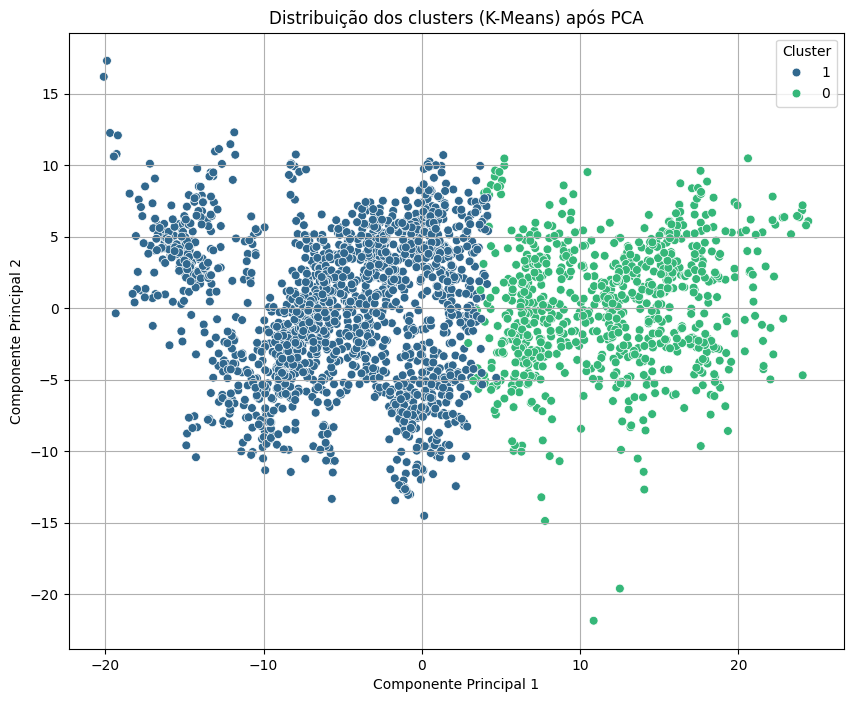

In [25]:
# Projetamos os dados em 2D via PCA para inspecionar visualmente os clusters encontrados.
# A dispersão ajuda a justificar conclusões sobre sobreposição entre sinais e intérpretes no espaço reduzido.
pca_transformador = PCA(n_components=2, random_state=RANDOM_STATE)
coordenadas_pca = pca_transformador.fit_transform(X_clusterizacao_normalizado)
tabela_pca = pd.DataFrame(coordenadas_pca, columns=['PCA1', 'PCA2'])
tabela_pca['Cluster'] = rotulos_kmeans.astype(str)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tabela_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=40)
plt.title('Distribuição dos clusters (K-Means) após PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

**Visualização dos Clusters via PCA (2 Componentes):**

**Análise Visual do Gráfico:**

1. **Distribuição Espacial:**
   - **Cluster 0 (verde)**: Concentrado mais à direita (componente principal 1 positivo)
   - **Cluster 1 (azul)**: Concentrado mais à esquerda e centro
   - Há uma separação razoável entre os dois grupos

2. **Características dos Clusters:**
   
   **Cluster 1:**
   - Maior concentração no centro e esquerda do gráfico
   - Mais disperso verticalmente
   - Alguns outliers na região superior esquerda
   
   **Cluster 0:**
   - Concentrado mais à direita
   - Distribuição mais compacta
   - Menos outliers visíveis

3. **Sobreposição:**
   - Existe sobreposição na região central (PCA1 entre -5 e 5)
   - Mas a maioria das amostras está claramente separada
   - Isso corrobora o Silhouette Score médio de 0.82 do HAC Average

4. **Outliers:**
   - Alguns pontos azuis isolados na extrema esquerda superior
   - Podem representar sinais ou estilos atípicos
   - Não comprometem a estrutura geral

**Interpretação dos Componentes Principais:**

- **PCA1 (horizontal)** captura a maior variância
- **PCA2 (vertical)** captura a segunda maior variância
- Juntos, explicam uma fração da variância total dos 279 atributos originais

**Hipóteses sobre a Divisão:**

Possíveis fatores causando a dicotomia:

1. **Por Intérprete:** 
   - Cluster 0 poderia agrupar intérpretes com estilo similar
   - Cluster 1 poderia agrupar intérpretes com outro estilo

2. **Por Complexidade do Sinal:**
   - Cluster 0: sinais mais simples/estáticos
   - Cluster 1: sinais mais complexos/dinâmicos

3. **Por Região Corporal Dominante:**
   - Cluster 0: sinais que usam principalmente mãos
   - Cluster 1: sinais que envolvem braços e corpo

**Validação Visual vs. Métrica:**

- A separação visual confirma o alto Silhouette Score (0.82)
- Os clusters são distinguíveis, embora não perfeitamente separados
- A redução para 2D preservou a estrutura razoavelmente bem

**Conclusão:** A visualização PCA confirma que existe uma **estrutura binária clara** nos dados de sinais em Libras. O HAC Average identificou com sucesso dois grupos principais com boa separação espacial. Pra entender melhor o significado desta divisão, seria necessário analisar a composição dos clusters em termos de sinais e intérpretes específicos.

---

### Conclusão Final

O modelo demonstrou que **é possível reconhecer sinais em Libras com acurácia superior a 98%** utilizando features estatísticas simples extraídas de keypoints de pose. O sucesso de modelos relativamente simples (Random Forest) indica que o problema está bem modelado e que as características extraídas capturam efetivamente a essência gestual da linguagem de sinais.

A análise não-supervisionada revelou uma estrutura binária interessante nos dados, sugerindo que existem padrões de alto nível além da classificação granular dos 25 sinais individuais.
